#### Imports

In [1]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

In [2]:
YEAR = 1990

# OCR with Adobe Acrobat and extraction with fitz

In [3]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

### Extract text

In [4]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_{}.pdf".format(YEAR))
print('Number of pages:', len(doc))

Number of pages: 471


In [5]:
def text_to_rows(text, threshold):
    '''
    Splits a list of into rows.
    Inputs:
        Text: a list of tuple containing individual words and their positions
        Threshold: the distance between lines
    Outputs:
        List of list that represent rows.
    '''
    if text == []:
        return []
    text_by_row = []
    temp = []
    init_y = text[0][1] #y0
    i = 0
    while i < len(text):
        if (text[i][1] < init_y + threshold) and (text[i][1] > init_y - threshold):
            temp.append(text[i][4])
        else:
            text_by_row.append(temp)
            temp = [text[i][4]]
            init_y = int(text[i][1])
        i += 1
    text_by_row.append(temp)
    return text_by_row

In [6]:
def text_to_rows(text, threshold):
    '''
    Splits a list of into rows.
    Inputs:
        Text: a list of tuple containing individual words and their positions
        Threshold: the distance between lines
    Outputs:
        List of list that represent rows.
    '''
    if text == []:
        return []
    row_centroids = []
    text_by_row = []
    for word in text:
        i = 0
        newline = True
        while i < len(row_centroids):
            if (word[1] < row_centroids[i] + threshold) and (word[1] > row_centroids[i] - threshold):
                text_by_row[i].append(word) #text_by_row[i] += [word[4]]
                newline = False
                break
            i += 1
        if newline:
            row_centroids.append(word[1])
            text_by_row.append([word]) #text_by_row.append([word[4]])
    return text_by_row

- Extract keys

In [7]:
abbr_keys = {}

In [8]:
#keys for treatment
pagen = 7
words = doc[pagen - 1].getText("words")
words = text_to_rows(words, 5)

In [14]:
key = 'AL'
val = 'Alcoholism Services only'
for line in words[6:-5]:
    line = [word[4] for word in line]
    i = 0
    if line[-1][-1] != ':':
        while i < len(line):
            if i == len(line) - 1:
                val += ' ' + line[i]
                abbr_keys[key] = val
                i += 1
            elif line[i].isupper() and line[i+1] == '=':
                abbr_keys[key] = val
                key = line[i]
                val = line[i + 2]
                i += 3
            else:
                val += ' ' + line[i]
                i += 1

In [15]:
abbr_keys['TX'] = "Treatment Unit"
abbr_keys['CI'] = "Central Intake Unit"
abbr_keys['PV'] = "Prevention Unit"
abbr_keys['OT'] = "Other Unit"

In [16]:
#keys for language
#None

In [17]:
abbr_keys

{'TX': 'Treatment Unit',
 'CI': 'Central Intake Unit',
 'PV': 'Prevention Unit',
 'OT': 'Other Unit',
 'AL': 'Alcoholism Services only',
 'DA': 'Drug Abuse Services only',
 'AD': 'Alcoholism and Drug Abuse Services',
 'RR': 'Residential (24-hour care)',
 'DT': 'Detoxification (24-hour care)',
 'AM': 'Ambulatory (less than 24-hour care)',
 'B': 'Blacks',
 'W': 'Woman',
 'H': 'Hispanics',
 'PG': 'Pregnant Users',
 'AI': 'American Indian/Alaskan Natives',
 'CU': 'Cocaine Users',
 'A': 'AIDS Patients',
 'IV': 'IV Drug Users',
 'HV': 'HIV Positives',
 'EA': 'EAP Program Services',
 'PI': 'Public Inebriates',
 'DW': 'DWI/ASAP Services',
 'Y': 'Youth TX Treatment Unit CI Central Intake Unit PV Prevention Unit',
 'MM': 'Methadone Unit OT Other Unit'}

In [18]:
len(abbr_keys)

24

In [30]:
# add keys not included in front page but appeared elsewhere?

- Explore text

In [19]:
firstpagen = 16

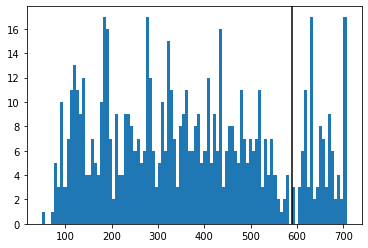

In [20]:
# - explore the page set up - 
# select a page
words = doc[16 - 1].getText("words")
# check the y distribution to remove top and bottom crap...
y0s = [word[1] for word in words]
a = plt.hist(y0s, bins = 100)
#plt.axvline(35, color='black')
plt.axvline(590, color='black')
#pages with the box of keys

- Read text from PDF

In [21]:
def clean_text(words):
    if [word for word in words if word[1] < 70]:
        #find the position of the state name
        state_pos = [word[0] for word in words if word[1] < 70][0]
        #if state name is in the middle means there is a box of keys at the end of page
        #cut the box with keys
        if (state_pos > 150) and (state_pos < 350):
            words = [word for word in words if word[1] < 590]
    #cut state name and page number
    return [word for word in words if (word[1] > 70 and word[1] < 700)]

In [105]:
def split_MOUD(col_text):
    '''
    '''
    list_MOUD = []
    if not col_text:
        return []
    if (col_text[1][0][1] - col_text[0][0][1]) > 15: #y0 of first line first word
        temp = [[word[4] for word in col_text[1]]]
        i = 2
    else:
        temp = [[word[4] for word in col_text[0]]] 
        i = 1
    while i < len(col_text) - 1:
        if any(char.isdigit() or char.isalpha() for char in ''.join([word[4] for word in col_text[i]])):
            if (col_text[i][0][1] - col_text[i-1][0][1]) < 15:
                temp.append([word[4] for word in col_text[i]])
            elif (col_text[i][0][1] - col_text[i-1][0][1]) > 15 and (col_text[i+1][0][1] - col_text[i][0][1]) < 15:
                if (len(temp) > 2):
                    list_MOUD.append(temp)
                    temp = [[word[4] for word in col_text[i]]]
                else:
                    temp.append([word[4] for word in col_text[i]])
        i += 1
    temp.append([word[4] for word in col_text[-1]])
    list_MOUD.append(temp)
    return list_MOUD

In [85]:
# col_text = get_words_in_box(doc[firstpagen-1], 199, 388)[0]
# split_MOUD(col_text)

In [86]:
def get_words_in_box(page, col1lim, col2lim):
    '''
    Extract words from each column of the PDF.
    '''
    thres = 4.5 #5
    page_txt = []
    words = page.getText("words") 
    words = clean_text(words)
    #get three columns
    col1_txt = text_to_rows([word for word in words if word[0] < col1lim], thres)
    page_txt.append(split_MOUD(col1_txt)) 
    col2_txt = text_to_rows([word for word in words if ((word[0] > col1lim) and (word[0] < col2lim))], thres)
    page_txt.append(split_MOUD(col2_txt))
    col3_txt = text_to_rows([word for word in words if word[0] > col2lim], thres)
    page_txt.append(split_MOUD(col3_txt)) 
    return page_txt

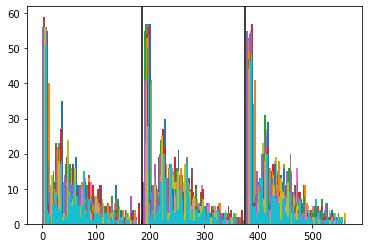

In [25]:
#to find column seperation
for pagen in range(100, 200, 2):
    words = doc[pagen - 1].getText("words")
    words = clean_text(words)
    x0s = [word[0] for word in words]
    a = plt.hist(x0s, bins = 170)
    
plt.axvline(185, color='black')
plt.axvline(375, color='black')

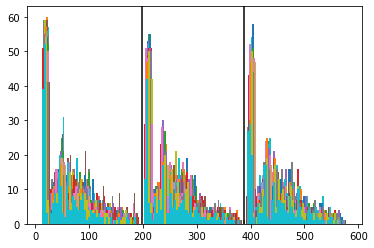

In [26]:
#to find column seperation
for pagen in range(101, 200, 2):
    words = doc[pagen - 1].getText("words")
    words = clean_text(words)
    x0s = [word[0] for word in words]
    a = plt.hist(x0s, bins = 150)
    
plt.axvline(199, color='black')
plt.axvline(388, color='black')

In [27]:
#testing
#get_words_in_box(doc[firstpagen - 1], 35, 740, 217, 388)
#page with some blanck
#get_words_in_box(doc[24 - 1], 35, 740, 217, 388)

In [106]:
#run
data = []
for pagen in range(firstpagen, len(doc) + 1):
    if pagen%2 == 1:
        data.append(get_words_in_box(doc[pagen-1], 199, 388))
    else:
        data.append(get_words_in_box(doc[pagen-1], 185, 375))

In [107]:
data[0][0]

[[['SHELBY', 'MEDICAL', 'CENTER'],
  ['RESTORE', 'PROGRAMS'],
  ['1000', 'FIRST', 'STREET', 'NORTH'],
  ['ALABASTER&', 'AL', '35007'],
  ['(', '205', ')', '663-8663'],
  ['»»', 'AO', 'DT', 'RR', '8', 'CU', 'Iy', 'EA', 'TX', 'Py', '«»'],
  ['W']],
 [['LIGHTHOUSE', 'OF', 'TALLAPOOSA', 'COUNTY', 'INC'],
  ['204', 'CALHOUN', 'STREET'],
  ['ALEXANDER', 'CITY&', 'AL', '35010'],
  ['(205', ')', '234-4894'],
  ['«»', 'AD', 'RR', 'TX', 'OT', '»«']],
 [['PARKSIDE', 'RECOVERY', 'CENTER', 'AT'],
  ['RUSSELL', 'HOSPITAL'],
  ['609', 'HIGHWAY', '22', 'WEST'],
  ['ALEXANDER', 'CITY&', 'AL', '35010'],
  ['(', '205', ')', 'Iy'],
  ['329-7391'],
  ['»«', 'AD', 'DT', 'AM', 'W', 'A', '8', 'H', 'AI', 'Hy', 'PI', 'CU', '»«'],
  ['«»', 'TX', 'CI', 'Py', '«»']],
 [['AGENCY', 'FOR', 'SUBSTANCE', 'ABUSE', 'PREY', 'OF'],
  ['CALHOUN', 'AND', 'CLEBURNE', 'COUNTIES'],
  ['1302', 'NOBLE', 'STREET'],
  ['ANNISTON,', 'AL', '36201'],
  ['(', '205', ')'],
  ['237-8131'],
  ['»»', 'AD', 'EA', 'Py', '««']],
 [['ANNISTON'

In [108]:
data[200][2] 

[[['PROSPECT', 'HOUSE', 'INC'],
  ['OUTPATIENT', 'SUBSTANCE', 'ABUSE', 'SERVICES'],
  ['110', 'LANCASTER', 'STREET'],
  ['WORCESTER&', 'MA', '01609'],
  ['(', '508)', '799-0702'],
  ['»»', 'AD', 'Y', 'A', 'B', 'AI', 'CU', 'IV', 'PG', '«»'],
  ['AM', 'W', 'H', 'HV', '«»'],
  ['TX', 'CI', 'Py', '«»']],
 [['PROSPECT', 'HOUSE', 'INC'],
  ['STRAIGHT', 'TALK/YOUTH', 'INTERVENTION'],
  ['110', 'LANCASTER', 'STREET'],
  ['WORCESTER&', 'MA', '01609'],
  ['(', '508', ')', '799-0702'],
  ['«»', 'AD', 'Py', '«»']],
 [['SAINT', 'VINCENTS', 'HOSPITAL'],
  ['DEPT', 'OF', 'ALCOHOL', 'AND', 'DRUG', 'SERVICES/Op'],
  ['25', 'WINTHROP', 'STREET'],
  ['WORCESTER&', 'MA', '01604'],
  ['(', '508', ')', '798-6107', 'EXT.', '6108'],
  ['»»', 'AD', 'AM', 'Y', 'A', 'HV', 'CU', 'IV', 'PG', 'EA', '««'],
  ['W', 'DW'],
  ['TX']],
 [['SPECTRUM', 'ADDICTION', 'SERVICES', 'INC'],
  ['DETOXIFICATION', 'CENTER'],
  ['305', 'BELMONT', 'STREET'],
  ['BRYAN', 'BUILDING', 'WARD', '2E'],
  ['WORCESTER&', 'MA', '01604'],
  [

# Write data into csv

### Checking + cleaning each part of data

- keys

In [112]:
def clean_keys(line):
    line = [key.replace('»', '').replace('«', '').replace('8', 'B').replace('y', 'V')\
            .replace('AO', 'AD').replace('AN', 'AM').replace('w', 'W') for key in line]
    line = [key for key in line if key.strip() != '']
    line = [key.replace('OT', 'DT') for key in line[:-1]] + [line[-1]]
    return line

In [61]:
def check_keys_warning(line):
    print("Please check:", line)
    for key in line:
        if key not in abbr_keys:
            print(key, 'not in abbr_keys')

def is_keys(line):
    '''
    Check if the line (list of list) is a list of keys
    '''
    if sum([len(key) for key in line])/len(line) > 2: #average length of word
        return False
    line = clean_keys(line)
    if not any(x not in abbr_keys for x in line):
        return True
    if line[0] in abbr_keys:
        if (len(line) > 2 and line[1] in abbr_keys) or (len(line) > 3 and line[2] in abbr_keys):
            check_keys_warning(line)
    elif len(line) > 2 and line[1] in abbr_keys:
        check_keys_warning(line)
    return False

In [62]:
# sample_keys = (['»»', 'AO', 'DT', 'RR', '8', 'CU', 'Iy', 'EA', 'TX', 'Py', '«»'],
#                ['»«', 'AD', 'AM', 'W', 'TX', 'Py', '»«'],
#                ['««', 'DA', 'RR', 'AN', 'Y', 'A', '8', 'H', 'AI', 'HV', 'IV', 'TX', '»»'],
#               ['W'])
# for keys in sample_keys:
#     print(is_keys(keys))

- city, state, zip

In [63]:
def is_citystatezip(line):
    if line[-1].isnumeric() and len(line[-1]) == 5 and line[-2].isupper() and len(line[-2]) == 2:
        return True
    return False

def clean_citystatezip(line):
    line = [word for word in line if word != 'I']
    return [' '.join(line[:-2]).replace('&', ''), line[-2], line[-1]]

In [64]:
# sample_states = [['NAPA&', 'CA', '94558'], 
#                  ['NAPA', 'I', 'CA', '94558'], 
#                 ['BAY', 'PINES&', 'FL', '33504'],
#                 ['BELLE', 'GLADE', 'FL', '33430']]
# for line in sample_states:
#     print(is_citystatezip(line))
#     print(clean_citystatezip(line))

- Contact

In [99]:
def is_contact(line):
    if re.match(r'(.*)\([0-9]{3}\)', ''.join(line)):
        return True
    if re.match(r'(.*)[0-9]{3}-[0-9]{4}', ''.join(line)):
        return True
    return False

def clean_contact(line):
    if re.match(r'(.*)\([0-9]{3}\)', ''.join(line)):
        return ''.join(line).replace('&', '')
    return ' '.join(line).replace('&', '')

In [101]:
# sample_contacts = [['(', '813', ')', '533-4139'],
#                   ['&', '(407)', '844-6400'],
#                   ['(', '508)', '799-0702'],
#                   ['&', '205', '438-4684']]
# for contact in sample_contacts:
#     print(is_contact(contact))
#     print(clean_contact(contact))

- Address

In [67]:
address_indicators = ['ROAD', 'HIGHWAY', 'ROUTE', 'BUILDING', 'STREET', 'AVENUE', 'SUITE', 'SUITES', 'DRIVE', \
                      'BOULEVARD', 'ANNEX', 'STREETS', 'FLOOR', 'REAR', 'ROOM', 'BASEMENT'] ##
name_indicators = ['CLINIC', 'MEDICAL', 'INC', 'HEALTH', 'SERVICES', 'TREATMENT']

def is_address(line):
    if (not line[0].replace('-', '').isnumeric()) and any(x in line for x in name_indicators):
        return False
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

In [68]:
sample_add = [['26', 'QUEEN', 'STREET']]
for add in sample_add:
    print(is_address(add))

True


- Write data

In [113]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) < 2:
            print(facil)
        if len(facil) > 2:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('') 
            #name3
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]) and not is_keys(facil[i]):##
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address3
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(clean_contact(facil[i]))
                i += 1
                while i < len(facil):
                    if is_contact(facil[i]):
                        data_holder[-1] += ' ' + clean_contact(facil[i])
                        i += 1
                    else:
                        break
            else:
                data_holder.append('')
#             #website
#             if facil[i][0].split('.')[-1] == 'org' or facil[i][0].split('.')[0] == 'www' or facil[i][0].split('.')[-1] == 'com':
#                 data_holder.append(' '.join(facil[i]))
#                 i += 1
#             else:
#                 data_holder.append('')
#             #note
#             if not is_keys(facil[i]):
#                 data_holder.append(' '.join(facil[i]))
#                 i += 1
#             else:
#                 data_holder.append('')
            #keys
            data_holder.append('')
            for keys in facil[i:]:
                data_holder[-1] += '/'.join(clean_keys(keys)) + '/'
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [114]:
filename = "{}.csv".format(YEAR)
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", 'Name3', "Address1", "Address2", "Address3", "City", "State", "ZIP_Code", "Contact", "Website", "Note", "Keys"])

In [115]:
pagen = 15

for page in data[0:5]:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        page_data_holders = clean_col_data(col)
        with open(filename, 'a', newline = '') as file:
            writer = csv.writer(file)
            writer.writerows(page_data_holders)
        print('fin', end = '')
    pagen += 1
    print('')

Page: 15.......fin........fin.......fin
Page: 16.......fin.........fin.........fin
Page: 17..........fin.......fin.....fin
Page: 18.......fin........fin.......fin
Page: 19........fin.........fin........fin


In [109]:
# #check error data
data[19-15][2-1]

[[['LAKESIDE', 'RECOVERY', 'CTR', 'INC/FAIRBANKS'],
  ['1001', 'NOBLE', 'STREET'],
  ['SUITE', '240'],
  ['FAIRBANKS&', 'AK', '99701'],
  ['(', '907)', '456-4526', 'PV«»'],
  ['»«AD', 'AMW', 'Y', 'AI', 'CUTXCI']],
 [['SALVATION', 'ARMY'],
  ['DRUG', 'ABUSE', 'TREATMENT', 'PROGRAM'],
  ['117', 'FIRST', 'AVENUE'],
  ['FAIRBANKS&', 'AK', '99707'],
  ['I907)', '452-5005'],
  ['»»', 'AD', 'AM', 'A', 'AI', 'HV', 'IV', 'TX', 'MM', '»»']],
 [['TANANA', 'CHIEFS', 'CONFERENCE', 'INC'],
  ['1302', '21ST', 'AVENUE'],
  ['I', 'AIRBANKS', '&', 'AK', '907)', '452-2446'],
  ['99701'],
  ['»»', 'AO', 'AM', 'AI', 'TX', 'PV', 'OT', '«»']],
 [['FORT', 'WAINWRIGHT', 'ALCOHOL', 'AND'],
  ['DRUG', 'ABUSE', 'PREY', 'CONTROL', 'PROG', '(ADAPCP', ')'],
  ['APVR/FW/PA/ADA'],
  ['BUILDING', '3401'],
  ['FORT', 'WAINWRIGHT&', 'AK', '99703'],
  ['(907)', '353-7203'],
  ['»»', 'AD', 'DT', 'AM', 'EA', 'DW', 'TX', 'CI', 'PV»«']],
 [['TANANA', 'CHIEFS', 'CONFERENCE', 'INC'],
  ['YUKON', 'FLATS', 'CARE'],
  ['FORT', 'YU

- Rewrite data in problem pages

In [46]:
# ^^

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [47]:
import pandas as pd

In [48]:
df = pd.read_csv("{}.csv".format(YEAR))
df

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Website,Note,Keys
0,Lighthouse of Tallapoosa County Inc,Substance Abuse Rehab Program/Resid,NaN,36 Franklin Street,NaN,NaN,Alexander City,AL,35010,(256)234-4894,NaN,NaN,SA/TX/HH/RL/CO/MN/SF/
1,Anniston Fellowship House Inc,NaN,NaN,106 East 22nd Street,NaN,NaN,Anniston,AL,36201,(256)236-7229,NaN,NaN,SA/TX/HH/RL/SF/
2,Calhoun Cleburne Mental Health Center,New Directions,NaN,407 Noble Street,NaN,NaN,Anniston,AL,36201,(256)236-8003 Hotlines: (256)236-8003 (256)236...,NaN,NaN,SA/TX/OP/AD/CO/DU/SF/MD/SI/PI/MI/SS/
3,Bridge Inc,Recovery Center for Teens/Ashville,NaN,474 10th Street,NaN,NaN,Ashville,AL,35953,(205)594-3111,www.bridgeinc.org,NaN,SA/TX/OP/AD/SF/MD/SI/PI/MI/PA/AH/
4,Northwest Alabama Treatment Center,NaN,NaN,4204 Edmonton Drive,NaN,NaN,Bessemer,AL,35022,(205)425-1200 Hotline: (205)805-3381,NaN,Methadone Clients Only,SA/TX/DT/MM/DM/OP/CO/HV/PW/WN/BC/SF/PI/AH/
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11055,Wyoming Substance Abuse Treatment and,Recovery Centers (WYSTAR),NaN,1003 Saberton Street,NaN,NaN,Sheridan,WY,82801,(307)672-2044,www.wystarrecovery.com,NaN,SA/TX/HH/RL/OP/PH/PW/WN/BC/SF/SI/PI/MI/SS/
11056,Wyoming Substance Abuse Treatment and,Recovery Centers (WYSTAR),NaN,1898 Fort Road,Building 64,NaN,Sheridan,WY,82801,(307)673-2510 Intake: (307)672-2044,www.wystarrecovery.com,NaN,SA/TX/RL/OP/CO/HV/GL/SE/MN/CJ/SF/PI/MI/SS/AH/
11057,Hot Springs County Counseling Service,NaN,NaN,121 South 4th Street,NaN,NaN,Thermopolis,WY,82443,(307)864-3138 Intake: (307)864-2247,NaN,NaN,MH/TX/OP/DU/SF/MD/SI/PI/MI/SS/PA/
11058,Peak Wellness Center,Substance Abuse Services,NaN,103 Park Avenue,NaN,NaN,Wheatland,WY,82201,(307)322-3190,www.sewmhc.org/programstaps.htm,NaN,MH/TX/OP/AD/CO/DU/SF/MD/MC/SI/PI/MI/


In [49]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[7])!=2:
        print(row)

In [50]:
#check if all zip codes are correct
df.dtypes

Name1       object
Name2       object
Name3       object
Address1    object
Address2    object
Address3    object
City        object
State       object
ZIP_Code     int64
Contact     object
Website     object
Note        object
Keys        object
dtype: object

- Correct in Pandas

In [51]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'and':
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [52]:
# def split_zip(zipc):
#     if '-' in zipc:
#         return zipc.split('-')
#     return [zipc, None]
# #split zip-code if zip code is in the format xxxxx-xxxx
# df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
# df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [53]:
df.to_csv('{}_c.csv'.format(YEAR), index = False)

## Summary stats

- Check keys

In [54]:
df = pd.read_csv('{}_c.csv'.format(YEAR))

In [57]:
Methadone_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Methadone' in val) or ('methadone' in val):
            Methadone_keys.append(key)
            print(key, val)

MM Methadone maintenance (facility may also use buprenorphine in maintenance)
DM Methadone detoxification (facility may also use buprenorphine in detoxification)


In [58]:
Buprenorphine_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Buprenorphine' in val) or ("buprenorphine" in val):
            Buprenorphine_keys.append(key)
            print(key, val)

MM Methadone maintenance (facility may also use buprenorphine in maintenance)
DM Methadone detoxification (facility may also use buprenorphine in detoxification)


In [59]:
Naltrexone_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Naltrexone' in val) or ('naltrexone' in val):
            Naltrexone_keys.append(key)
            print(key, val)

- Count keys

In [60]:
def count_key(df, key):
    '''
    Count the number MOUD with a certain key
    '''
    df[key] = df.apply(lambda row: key in row['Keys'].split('/'), axis = 1)
    return len(df[df[key] == True])

In [61]:
len(df)

11060

In [62]:
labels = []
MOUD_numbers = []

In [63]:
for key in Methadone_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    labels.append(abbr_keys[key] + '(' + key + ')')
    MOUD_numbers.append(n_MOUD_with_key)

MM : Methadone maintenance (facility may also use buprenorphine in maintenance) 		 925
DM : Methadone detoxification (facility may also use buprenorphine in detoxification) 		 664


In [64]:
for key in Buprenorphine_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    if (abbr_keys[key] + '(' + key + ')') not in labels:
        labels.append(abbr_keys[key] + '(' + key + ')')
        MOUD_numbers.append(n_MOUD_with_key)

MM : Methadone maintenance (facility may also use buprenorphine in maintenance) 		 925
DM : Methadone detoxification (facility may also use buprenorphine in detoxification) 		 664


In [65]:
for key in Naltrexone_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    if (abbr_keys[key] + '(' + key + ')') not in labels:
        labels.append(abbr_keys[key] + '(' + key + ')')
        MOUD_numbers.append(n_MOUD_with_key)

In [66]:
labels

['Methadone maintenance (facility may also use buprenorphine in maintenance)(MM)',
 'Methadone detoxification (facility may also use buprenorphine in detoxification)(DM)']

In [67]:
MOUD_numbers

[925, 664]

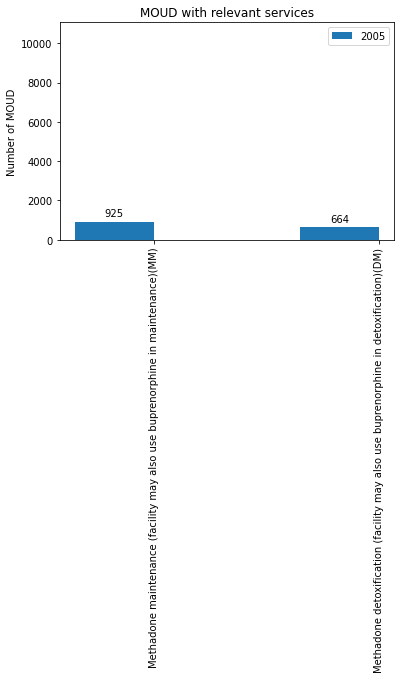

In [68]:
#barchart: https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, MOUD_numbers, width, label=str(YEAR))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of MOUD')
ax.set_title('MOUD with relevant services')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

plt.ylim(0, len(df))
plt.xticks(rotation=90)
plt.savefig('{}_stats.png'.format(YEAR), bbox_inches = 'tight')